In [ ]:
!pip install -r requirements.txt

In [1]:
import math
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wget
import zipfile
import cv2
import torch
import shutil
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as tfms
from poutyne import set_seeds, Model, ModelCheckpoint, CSVLogger, Experiment, StepLR
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision.utils import make_grid

In [2]:
batch_size = 64
image_size = 224
w, h = 218, 178  # the width and the hight of original images before resizing
set_seeds(48)
gender_index = 20  # in the CelebA dataset gender information is the 21th item in the attributes vector.
imagenet_mean = [0.485, 0.456, 0.406]  # mean of the ImageNet dataset for normalizing
imagenet_std = [0.229, 0.224, 0.225]  # std of the ImageNet dataset for normalizing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The running processor is...", device)

The running processor is... cuda


In [3]:
data_root = "datasets"

base_url = "https://graal.ift.ulaval.ca/public/celeba/"

# file_list = [
#     "img_align_celeba.zip",
#     "list_attr_celeba.txt",
#     "identity_CelebA.txt",
#     "list_bbox_celeba.txt",
#     "list_landmarks_align_celeba.txt",
#     "list_eval_partition.txt",
# ]

# # Path to folder with the dataset
# dataset_folder = f"{data_root}/celeba"
# os.makedirs(dataset_folder, exist_ok=True)

# for file in file_list:
#     url = f"{base_url}/{file}"
#     if not os.path.exists(f"{dataset_folder}/{file}"):
#         wget.download(url, f"{dataset_folder}/{file}")

# with zipfile.ZipFile(f"{dataset_folder}/img_align_celeba.zip", "r") as ziphandler:
#     ziphandler.extractall(dataset_folder)

In [4]:
transforms = tfms.Compose(
    [
        tfms.Resize((image_size, image_size)),
        tfms.ToTensor(),
        tfms.Normalize(imagenet_mean, imagenet_std),
    ]
)
train_dataset = datasets.CelebA(data_root, split="train", target_type=["attr"], transform=transforms)
valid_dataset = datasets.CelebA(data_root, split="valid", target_type=["attr"], transform=transforms)
test_dataset = datasets.CelebA(data_root, split="test", target_type=["attr"], transform=transforms)

In [ ]:
train_num = 5000
train_ratio = 0.7

train_subset = Subset(train_dataset, np.arange(1, int(train_num*train_ratio)))
valid_subset = Subset(valid_dataset, np.arange(1, int(train_num*(1-train_ratio))))
test_subset = Subset(test_dataset, np.arange(1, 1000))
train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

In [ ]:
class ClassifierLocalizer(nn.Module):
    def __init__(self, model_name, num_classes=2):
        super(ClassifierLocalizer, self).__init__()
        self.num_classes = num_classes

        # Create the CNN model
        model = getattr(models, model_name)(pretrained=True)

        if model_name == "resnet18":
            # Modify the final fully connected layer for ResNet
            num_features = model.fc.in_features
            model.fc = nn.Linear(num_features, num_classes)
        elif model_name == "alexnet":
            # Modify the last fully connected layer for AlexNet
            num_features = model.classifier[6].in_features
            model.classifier[6] = nn.Linear(num_features, num_classes)
        elif model_name == "vgg16":
            # Modify the last fully connected layer for VGG16
            num_features = model.classifier[6].in_features
            model.classifier[6] = nn.Linear(num_features, num_classes)
        else:
            raise ValueError("Unsupported model_name. Supported values are 'resnet', 'alexnet', and 'vgg16'.")

        self.model = model

    def forward(self, x):
        x = self.model(x)  # Extract features from CNN
        scores = x[:, : self.num_classes]  # Class scores
        return scores  # Output class scores

In [ ]:
class ClassificationRegressionLoss(nn.Module):
    def __init__(self):
        super(ClassificationRegressionLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss()  # size_average=False

    def forward(self, y_pred, y_true):
        loss_cls = self.ce_loss(y_pred, y_true[:, gender_index])  # Cross Entropy Error (for classification)
        return loss_cls

In [8]:
# network_list = [ 'resnet18', 'alexnet']
network_list = ['vgg16']
# learning_rate_list = [0.01,0.005,0.001]
learning_rate_list = [0.01,0.005,0.001]
# optimizer_list = ['SGD','RMSprop', 'Adam']
optimizer_list = ['RMSprop']
# momentum_list = [0.0, 0.2, 0.4]
momentum_list = [0.4]

In [9]:
loss_function = ClassificationRegressionLoss()

for network_name in network_list:
  network = ClassifierLocalizer(model_name=network_name)

  for optimizer_name in optimizer_list:
    for learning_rate in learning_rate_list:
      for momentum in momentum_list:
        if optimizer_name == 'SGD':
          optimizer = optim.SGD(network.parameters(), lr=learning_rate)
        elif optimizer_name == 'RMSprop':
          optimizer = optim.RMSprop(network.parameters(), lr=learning_rate)
        elif optimizer_name == 'Adam':
          optimizer = optim.Adam(network.parameters(), lr=learning_rate)
        # C:\Users\jayyx\Desktop\cnn\saves
        save_directory_path = f"C:/Users/jayyx/Desktop/cnn/saves/{network_name}_{optimizer_name}_{momentum}_{learning_rate}"

        exp = Experiment(
            save_directory_path,
            network,
            optimizer=optimizer,
            loss_function=loss_function,
            device=device,
        )
        exp.train(train_dataloader, valid_dataloader, epochs=30)

          
        # Remove files other than logs (that writes the losses for each epochs), as too much space taken up
        if os.path.exists(save_directory_path) and os.path.isdir(save_directory_path):
            # Get the name of the parent folder
            parent_folder_name = os.path.basename(save_directory_path)
        
            # Get the list of files and folders in the directory
            items = os.listdir(save_directory_path)
        
            # Iterate through the items in the directory
            for item in items:
                item_path = os.path.join(save_directory_path, item)
        
                # Check if the item is 'log.tsv'
                if item == 'log.tsv':
                    pass
                else:
                    if os.path.isfile(item_path):
                        # If it's a file (other than 'log.tsv'), remove it
                        os.remove(item_path)
                    elif os.path.isdir(item_path):
                        # If it's a directory, remove it and its contents
                        shutil.rmtree(item_path)

c:\Users\jayyx\Documents\GitHub\CZ4042-Project\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jayyx\Documents\GitHub\CZ4042-Project\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\jayyx\Documents\GitHub\CZ4042-Project\.venv\Lib\site-packages\poutyne\framework\model_bundle.py:751: UserWarning: tensorboard does not seem to be installed. To remove this warning, set the 'disable_tensorboard' flag to True or install tensorboard.
  return self._train(self.model.fit_generator, train_generator, 

Epoch:  1/30 Train steps: 55 Val steps: 24 6m4.18s loss: 44195452603445895250313216.000000 val_loss: 3334982533784672227295232.000000
Epoch 1: val_loss improved from inf to 3334982533784672227295232.00000, saving file to C:/Users/jayyx/Desktop/cnn/saves/vgg16_RMSprop_0.2_0.01\checkpoint_epoch_1.ckpt
Epoch:  2/30 Train steps: 55 Val steps: 24 5m36.73s loss: 43277164278200437101821952.000000 val_loss: 14051582394620000830750720.000000
Epoch:  3/30 Train steps: 55 Val steps: 24 5m41.71s loss: 40390329745391400555380736.000000 val_loss: 8727659467062893405536256.000000
Epoch:  4/30 Train steps: 55 Val steps: 24 5m59.09s loss: 39123891010179454359044096.000000 val_loss: 7244918973001805521223680.000000
Epoch:  5/30 Train steps: 55 Val steps: 24 6m1.32s loss: 38847339945680604617506816.000000 val_loss: 4751434678974924145557504.000000
Epoch:  6/30 Train steps: 55 Val steps: 24 6m6.89s loss: 39636000256900708815601664.000000 val_loss: 11163426186651658484711424.000000
Epoch:  7/30 Train steps

c:\Users\jayyx\Documents\GitHub\CZ4042-Project\.venv\Lib\site-packages\poutyne\framework\model_bundle.py:751: UserWarning: tensorboard does not seem to be installed. To remove this warning, set the 'disable_tensorboard' flag to True or install tensorboard.
  return self._train(self.model.fit_generator, train_generator, valid_generator, **kwargs)


Epoch:  1/30 Train steps: 55 Val steps: 24 5m51.87s loss: 29072523576829647794470912.000000 val_loss: 2643460405392016637165568.000000
Epoch 1: val_loss improved from inf to 2643460405392016637165568.00000, saving file to C:/Users/jayyx/Desktop/cnn/saves/vgg16_RMSprop_0.2_0.005\checkpoint_epoch_1.ckpt
Epoch:  2/30 Train steps: 55 Val steps: 24 5m51.87s loss: 28636329117771315464372224.000000 val_loss: 2339457308928173836075008.000000
Epoch 2: val_loss improved from 2643460405392016637165568.00000 to 2339457308928173836075008.00000, saving file to C:/Users/jayyx/Desktop/cnn/saves/vgg16_RMSprop_0.2_0.005\checkpoint_epoch_2.ckpt
Epoch:  3/30 Train steps: 55 Val steps: 24 5m49.72s loss: 28299343364392241342709760.000000 val_loss: 3299074802753216993820672.000000
Epoch:  4/30 Train steps: 55 Val steps: 24 5m51.68s loss: 27983729574283785866838016.000000 val_loss: 3447376545503074320384000.000000
Epoch:  5/30 Train steps: 55 Val steps: 24 5m52.23s loss: 27776706063546285503283200.000000 val_

c:\Users\jayyx\Documents\GitHub\CZ4042-Project\.venv\Lib\site-packages\poutyne\framework\model_bundle.py:751: UserWarning: tensorboard does not seem to be installed. To remove this warning, set the 'disable_tensorboard' flag to True or install tensorboard.
  return self._train(self.model.fit_generator, train_generator, valid_generator, **kwargs)


Epoch:  1/30 Train steps: 55 Val steps: 24 5m50.64s loss: 25851467074467774490214400.000000 val_loss: 1589263140532443682963456.000000
Epoch 1: val_loss improved from inf to 1589263140532443682963456.00000, saving file to C:/Users/jayyx/Desktop/cnn/saves/vgg16_RMSprop_0.2_0.001\checkpoint_epoch_1.ckpt
Epoch:  2/30 Train steps: 55 Val steps: 24 5m50.19s loss: 26043264473810886323077120.000000 val_loss: 1544294567381368307712000.000000
Epoch 2: val_loss improved from 1589263140532443682963456.00000 to 1544294567381368307712000.00000, saving file to C:/Users/jayyx/Desktop/cnn/saves/vgg16_RMSprop_0.2_0.001\checkpoint_epoch_2.ckpt
Epoch:  3/30 Train steps: 55 Val steps: 24 5m52.23s loss: 25911878946771114353754112.000000 val_loss: 1534235757387997236953088.000000
Epoch 3: val_loss improved from 1544294567381368307712000.00000 to 1534235757387997236953088.00000, saving file to C:/Users/jayyx/Desktop/cnn/saves/vgg16_RMSprop_0.2_0.001\checkpoint_epoch_3.ckpt
Epoch:  4/30 Train steps: 55 Val st

vgg16_SGD_0.0_0.001
C:/Users/jayyx/Desktop/cnn/saves/vgg16_SGD_0.0_0.001


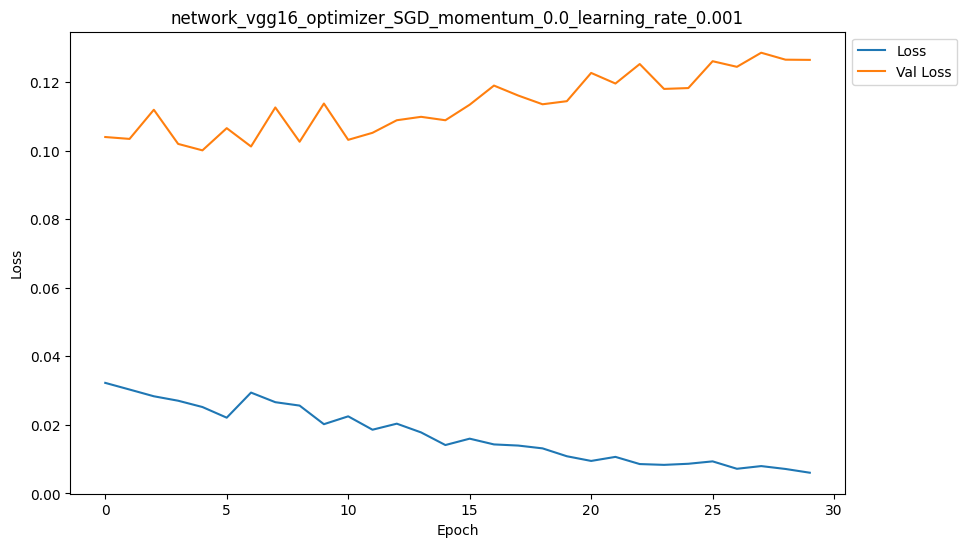

vgg16_SGD_0.0_0.005
C:/Users/jayyx/Desktop/cnn/saves/vgg16_SGD_0.0_0.005


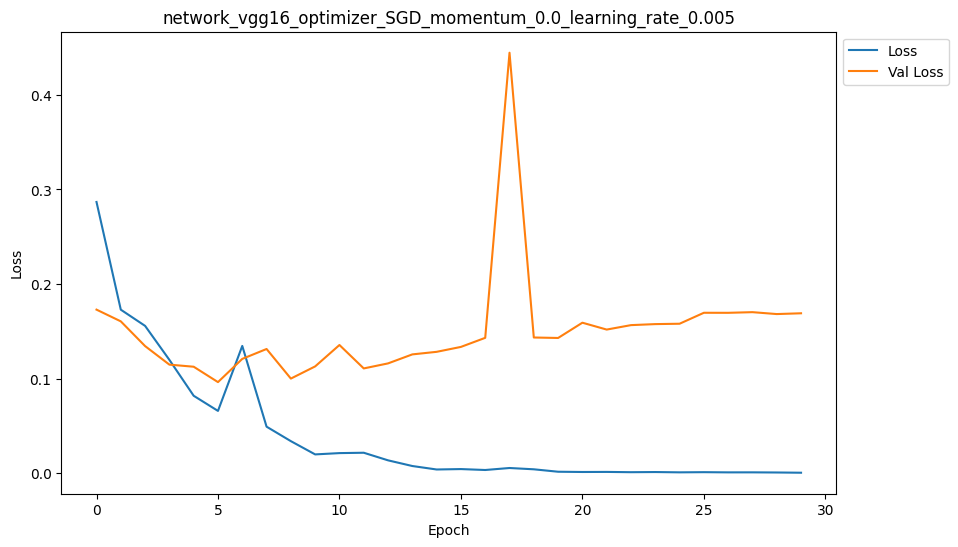

vgg16_SGD_0.0_0.01
C:/Users/jayyx/Desktop/cnn/saves/vgg16_SGD_0.0_0.01


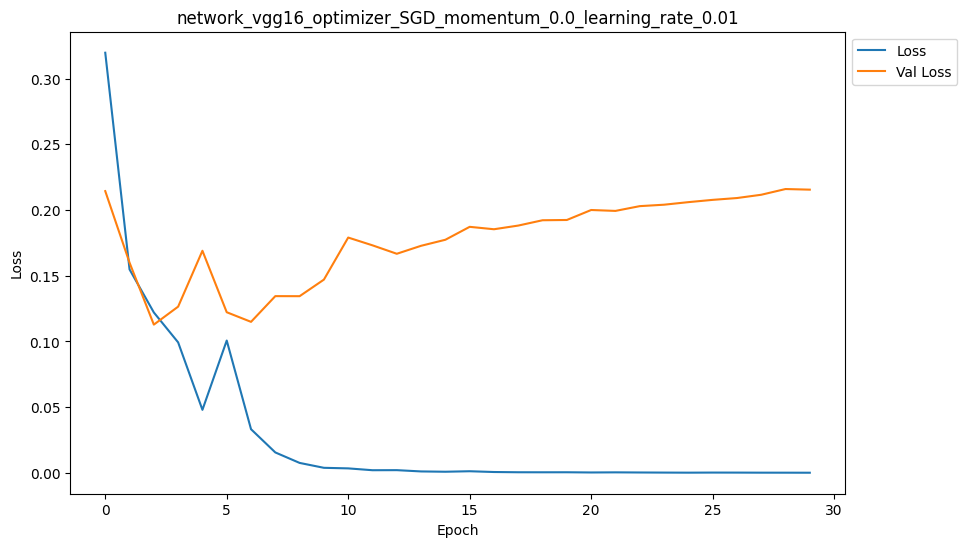

vgg16_SGD_0.2_0.001
C:/Users/jayyx/Desktop/cnn/saves/vgg16_SGD_0.2_0.001


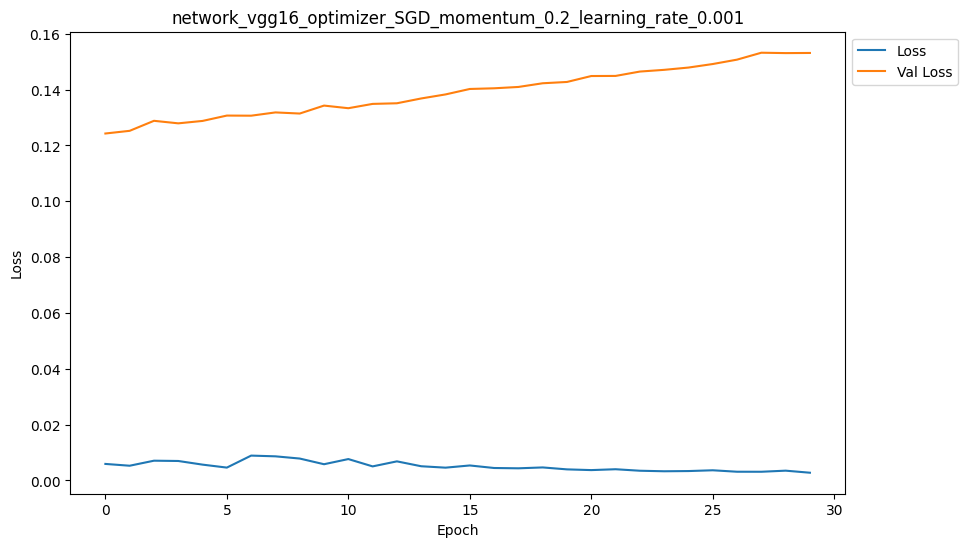

vgg16_SGD_0.2_0.005
C:/Users/jayyx/Desktop/cnn/saves/vgg16_SGD_0.2_0.005


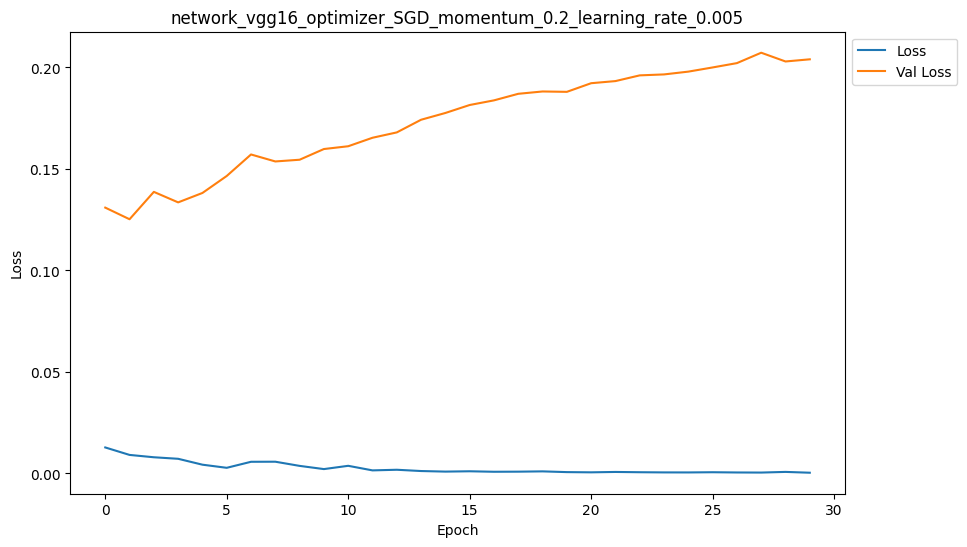

vgg16_SGD_0.2_0.01
C:/Users/jayyx/Desktop/cnn/saves/vgg16_SGD_0.2_0.01


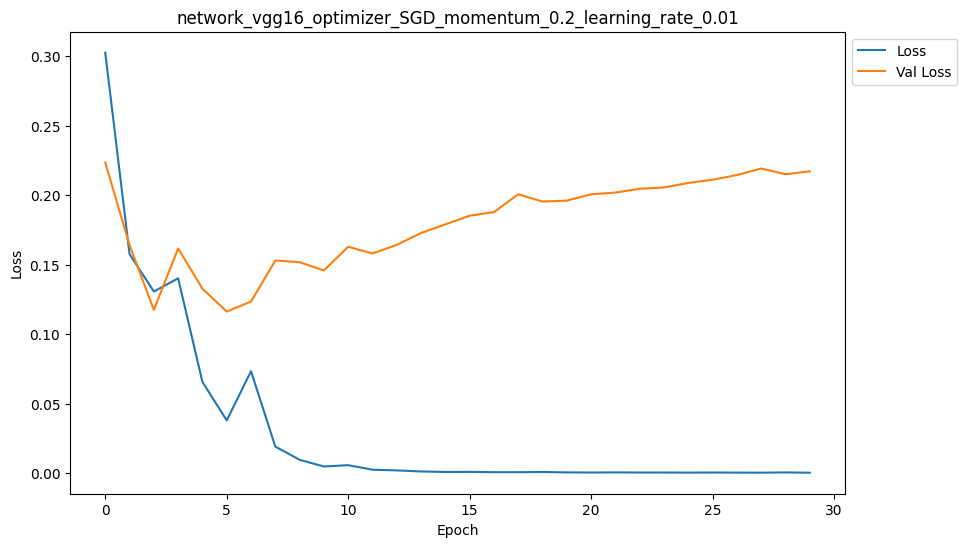

vgg16_SGD_0.4_0.001
C:/Users/jayyx/Desktop/cnn/saves/vgg16_SGD_0.4_0.001


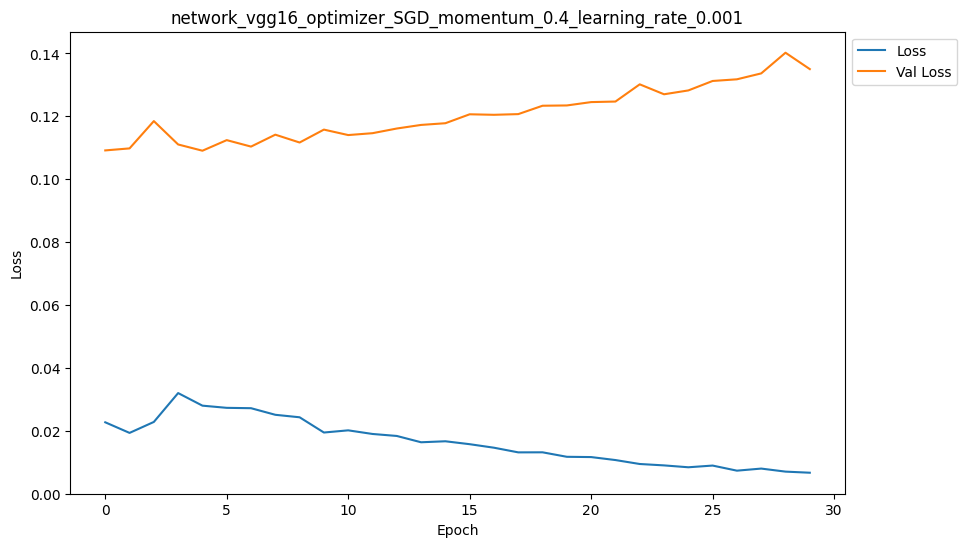

vgg16_SGD_0.4_0.005
C:/Users/jayyx/Desktop/cnn/saves/vgg16_SGD_0.4_0.005


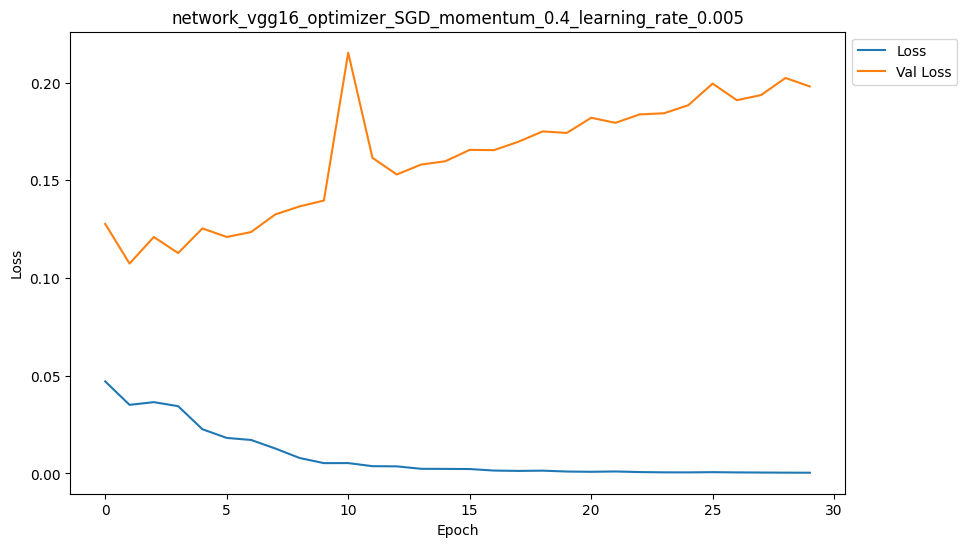

vgg16_SGD_0.4_0.01
C:/Users/jayyx/Desktop/cnn/saves/vgg16_SGD_0.4_0.01


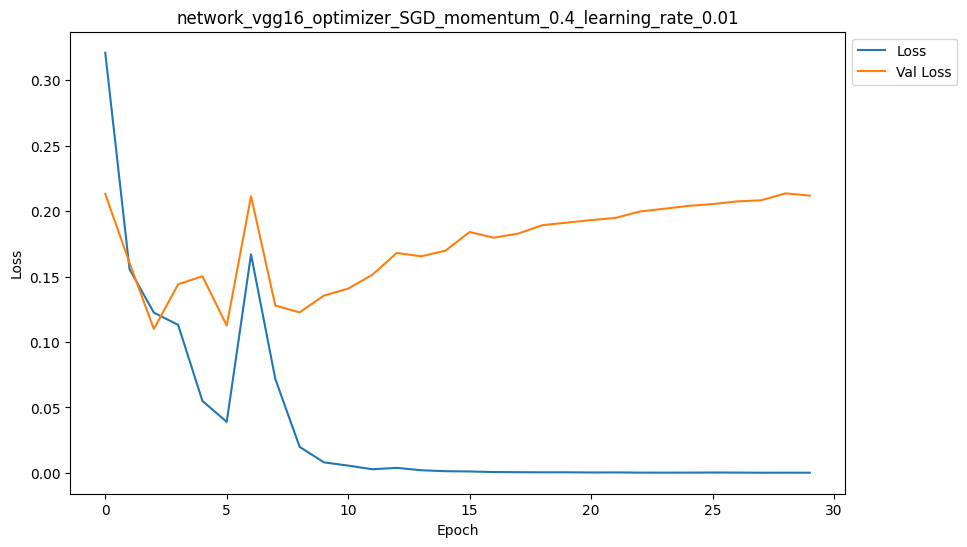

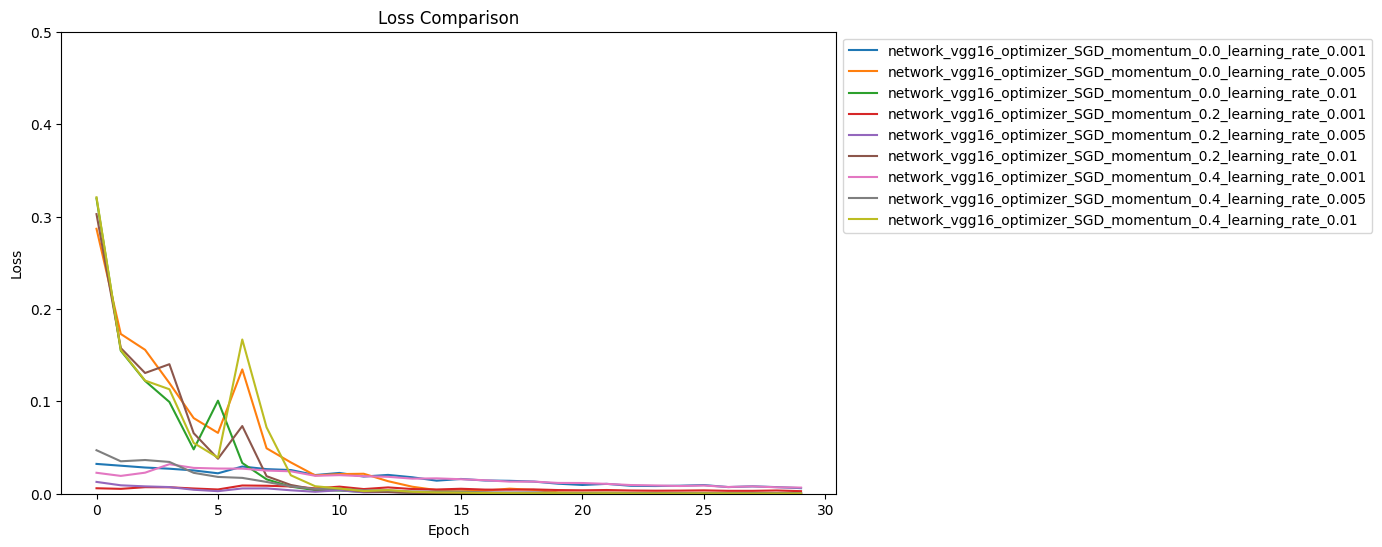

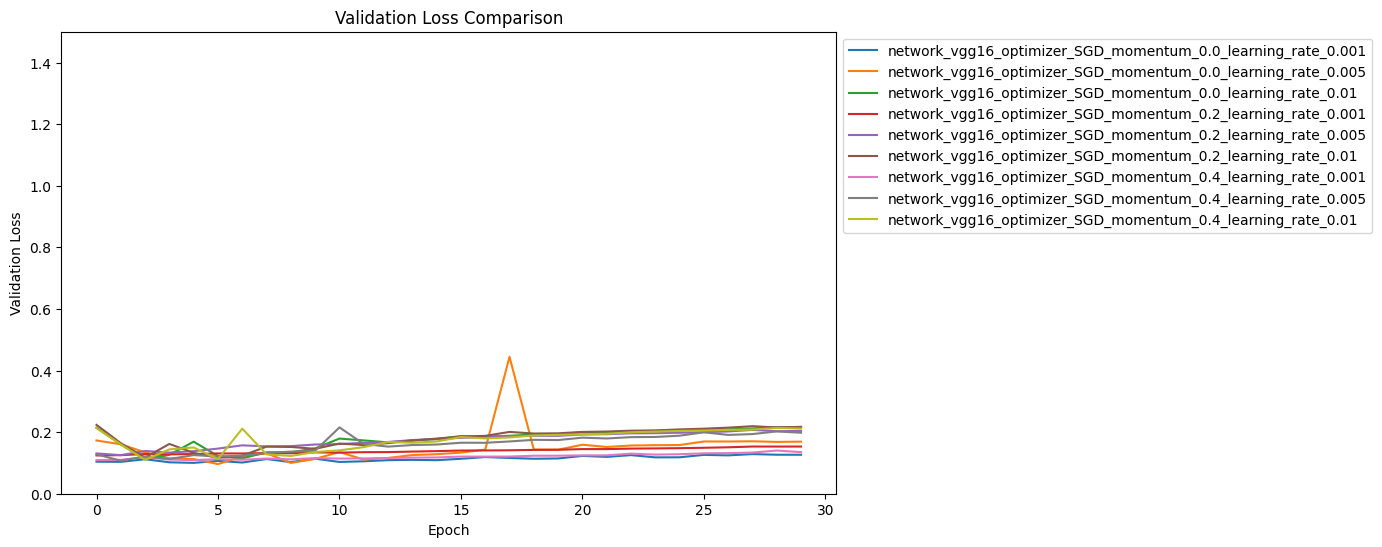

In [24]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define the directory where your .tsv files are located
directory = f"C:/Users/jayyx/Desktop/cnn/saves/"

# Initialize lists to store loss and val_loss data
all_loss_data = []
all_val_loss_data = []
plot_labels = []  # Store the labels for the individual plots

# Loop through the .tsv files in the directory
for filename in os.listdir(directory):
    print(filename)
    # if filename.endswith('.tsv') and 'vgg16' not in filename:
    file_path = os.path.join(directory, filename)
    print(file_path)
    # Extract information from the filename
    file_parts = filename.split('_')
    network_name = file_parts[0]
    optimizer_name = file_parts[1]
    momentum_number = file_parts[2]
    learning_rate_number = file_parts[3].replace('.tsv', '')

    # Read the TSV file into a DataFrame
    df = pd.read_csv(file_path + "/log.tsv", delimiter='\t')

    # Extract loss and val_loss columns
    loss_data = df['loss']
    val_loss_data = df['val_loss']

    # Append the data to the respective lists
    all_loss_data.append(loss_data)
    all_val_loss_data.append(val_loss_data)

    # Create individual line graphs for each '.tsv' file with labels
    plt.figure(figsize=(10, 6))
    plt.plot(loss_data, label='Loss')
    plt.plot(val_loss_data, label='Val Loss')
    title = f'network_{network_name}_optimizer_{optimizer_name}_momentum_{momentum_number}_learning_rate_{learning_rate_number}'
    plt.title(title)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    # Store the label for the individual plot
    plot_labels.append(title)

# Create a plot for all 'loss' data on the same axis with labels
plt.figure(figsize=(10, 6))
for loss_data, label in zip(all_loss_data, plot_labels):
    plt.plot(loss_data, label=label)
plt.title('Loss Comparison')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 0.5)  # Limit the y-axis for 'Loss'
plt.show()

# Create a plot for all 'val_loss' data on the same axis with labels
plt.figure(figsize=(10, 6))
for val_loss_data, label in zip(all_val_loss_data, plot_labels):
    plt.plot(val_loss_data, label=label)
plt.title('Validation Loss Comparison')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.ylim(0, 1.5)  # Limit the y-axis for 'Validation Loss'
plt.show()


In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define the directory where your .tsv files are located
directory = f"C:/Users/jayyx/Desktop/cnn/saves/"

# Initialize dictionaries to store loss and val_loss data by network
loss_by_network = {}
val_loss_by_network = {}

# Loop through the .tsv files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.tsv') and 'vgg16' not in filename:
        file_path = os.path.join(directory, filename)

        # Extract information from the filename
        file_parts = filename.split('_')
        optimizer_name = file_parts[1]
        momentum_number = file_parts[2]
        learning_rate_number = file_parts[3].replace('.tsv', '')
        network_name = file_parts[0]

        # Read the TSV file into a DataFrame
        df = pd.read_csv(file_path, delimiter='\t')

        # Extract loss and val_loss columns
        loss_data = df['loss']
        val_loss_data = df['val_loss']

        # # Check if all values are above 0.6
        # if all(val > 0.6 for val in loss_data) and all(val > 0.6 for val in val_loss_data):
        #     continue  # Skip this graph

        # Create a label in the desired format
        label = f'{optimizer_name}_{momentum_number}_{learning_rate_number}'

        # Check if the network exists in the dictionaries, and if not, create a new entry
        if network_name not in loss_by_network:
            loss_by_network[network_name] = {}
            val_loss_by_network[network_name] = {}

        if optimizer_name not in loss_by_network[network_name]:
            loss_by_network[network_name][optimizer_name] = {'labels': [], 'loss_data': []}
            val_loss_by_network[network_name][optimizer_name] = {'labels': [], 'val_loss_data': []}

        # Append the data to the respective dictionaries
        loss_by_network[network_name][optimizer_name]['labels'].append(label)
        loss_by_network[network_name][optimizer_name]['loss_data'].append(loss_data)
        val_loss_by_network[network_name][optimizer_name]['labels'].append(label)
        val_loss_by_network[network_name][optimizer_name]['val_loss_data'].append(val_loss_data)

# Create separate subplots for each network's 'loss' data
for network_name, optimizer_data in loss_by_network.items():
    num_optimizers = len(optimizer_data)
    fig, axs = plt.subplots(1, num_optimizers, figsize=(15, 5))

    for i, (optimizer_name, data) in enumerate(optimizer_data.items()):
        ax = axs[i]
        for label, loss_data in zip(data['labels'], data['loss_data']):
            ax.plot(loss_data, label=f'Loss - {label}')
        ax.set_title(f'Loss Comparison for {network_name} - {optimizer_name}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_ylim(0, 1)  # Limit the y-axis to (0, 1)
        ax.legend()

    plt.show()

# Create separate subplots for each network's 'val_loss' data
for network_name, optimizer_data in val_loss_by_network.items():
    num_optimizers = len(optimizer_data)
    fig, axs = plt.subplots(1, num_optimizers, figsize=(15, 5))

    for i, (optimizer_name, data) in enumerate(optimizer_data.items()):
        ax = axs[i]
        for label, val_loss_data in zip(data['labels'], data['val_loss_data']):
            ax.plot(val_loss_data, label=f'Val Loss - {label}')
        ax.set_title(f'Validation Loss Comparison for {network_name} - {optimizer_name}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Validation Loss')
        ax.set_ylim(0, 1)  # Limit the y-axis to (0, 1)
        ax.legend()

    plt.show()


In [ ]:
# import shutil
# shutil.rmtree('./saves', ignore_errors=True)